In [1]:
from utils import DataUtils, MetricUtils, PlotUtils
from HUGIMLClassifier import HUGIMLClassifier
from HUGIMLClassifierBNB import HUGIMLClassifierBNB
from HUGIMLClassifierL1 import HUGIMLClassifierL1
from hmeasure import h_score  
import pandas as pd, numpy as np, copy, optuna
import optuna.visualization as vis
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm_notebook
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,log_loss
%matplotlib inline

#### HUG-IML

60.5 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Training and evaluating on dataset: pimaIndianDiabetes
dataset: pimaIndianDiabetes (768, 8)  featureSize: (6, 2, 0) classSize: [(0, 500), (1, 268)]
all cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age', 'bmi', 'diabetesPedigre']
i/f cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age'] ['bmi', 'diabetesPedigreeFunction']
cat cols: []
params  : [('B', 7), ('L', 1), ('G', 0.005)]

Training model...
Making predictions...

Training and evaluating on dataset: Heloc
dataset: Heloc (9861, 23)  featureSize: (0, 23, 0) classSize: [(0, 5128), (1, 4733)]
all cols: ['MSinceOldestTra', 'ExternalRiskEst', 'NumTrades90Ever', 'NumRevolvingTra', 'NumTradesOpenin', 'NumInqLast6M', 'NumInqLast6Mexc', 'NumBank2NatlTra', 'PercentTradesNe', 'NumTotalTrades']
i/f cols: [] ['MSinceOldestTradeOpen', 'ExternalRiskEstimate', 'NumTrades90Ever2DerogPubRec', 'NumRevolvingTradesWBalance', 'NumTrad

,accuracy,f1,auc,hmeasure,logLoss
dataset,,,,,
pimaIndianDiabetes,0.7857,0.6374,0.8694,0.4814,0.4295
Heloc,0.7253,0.7114,0.7949,0.3099,0.5509
BankMarketingUCI,0.8989,0.3121,0.7831,0.3259,0.2813


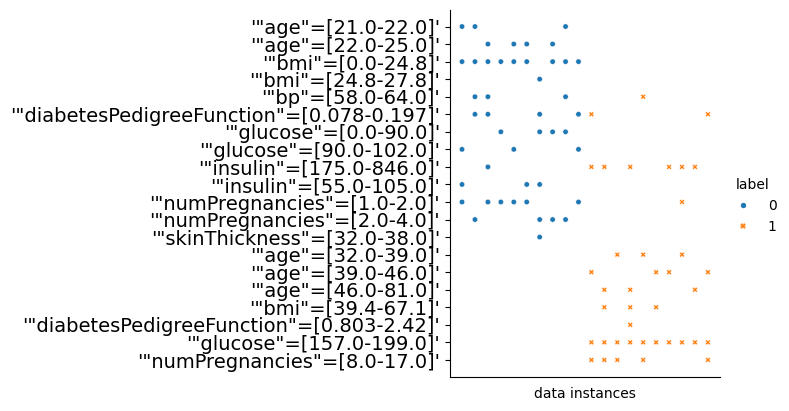

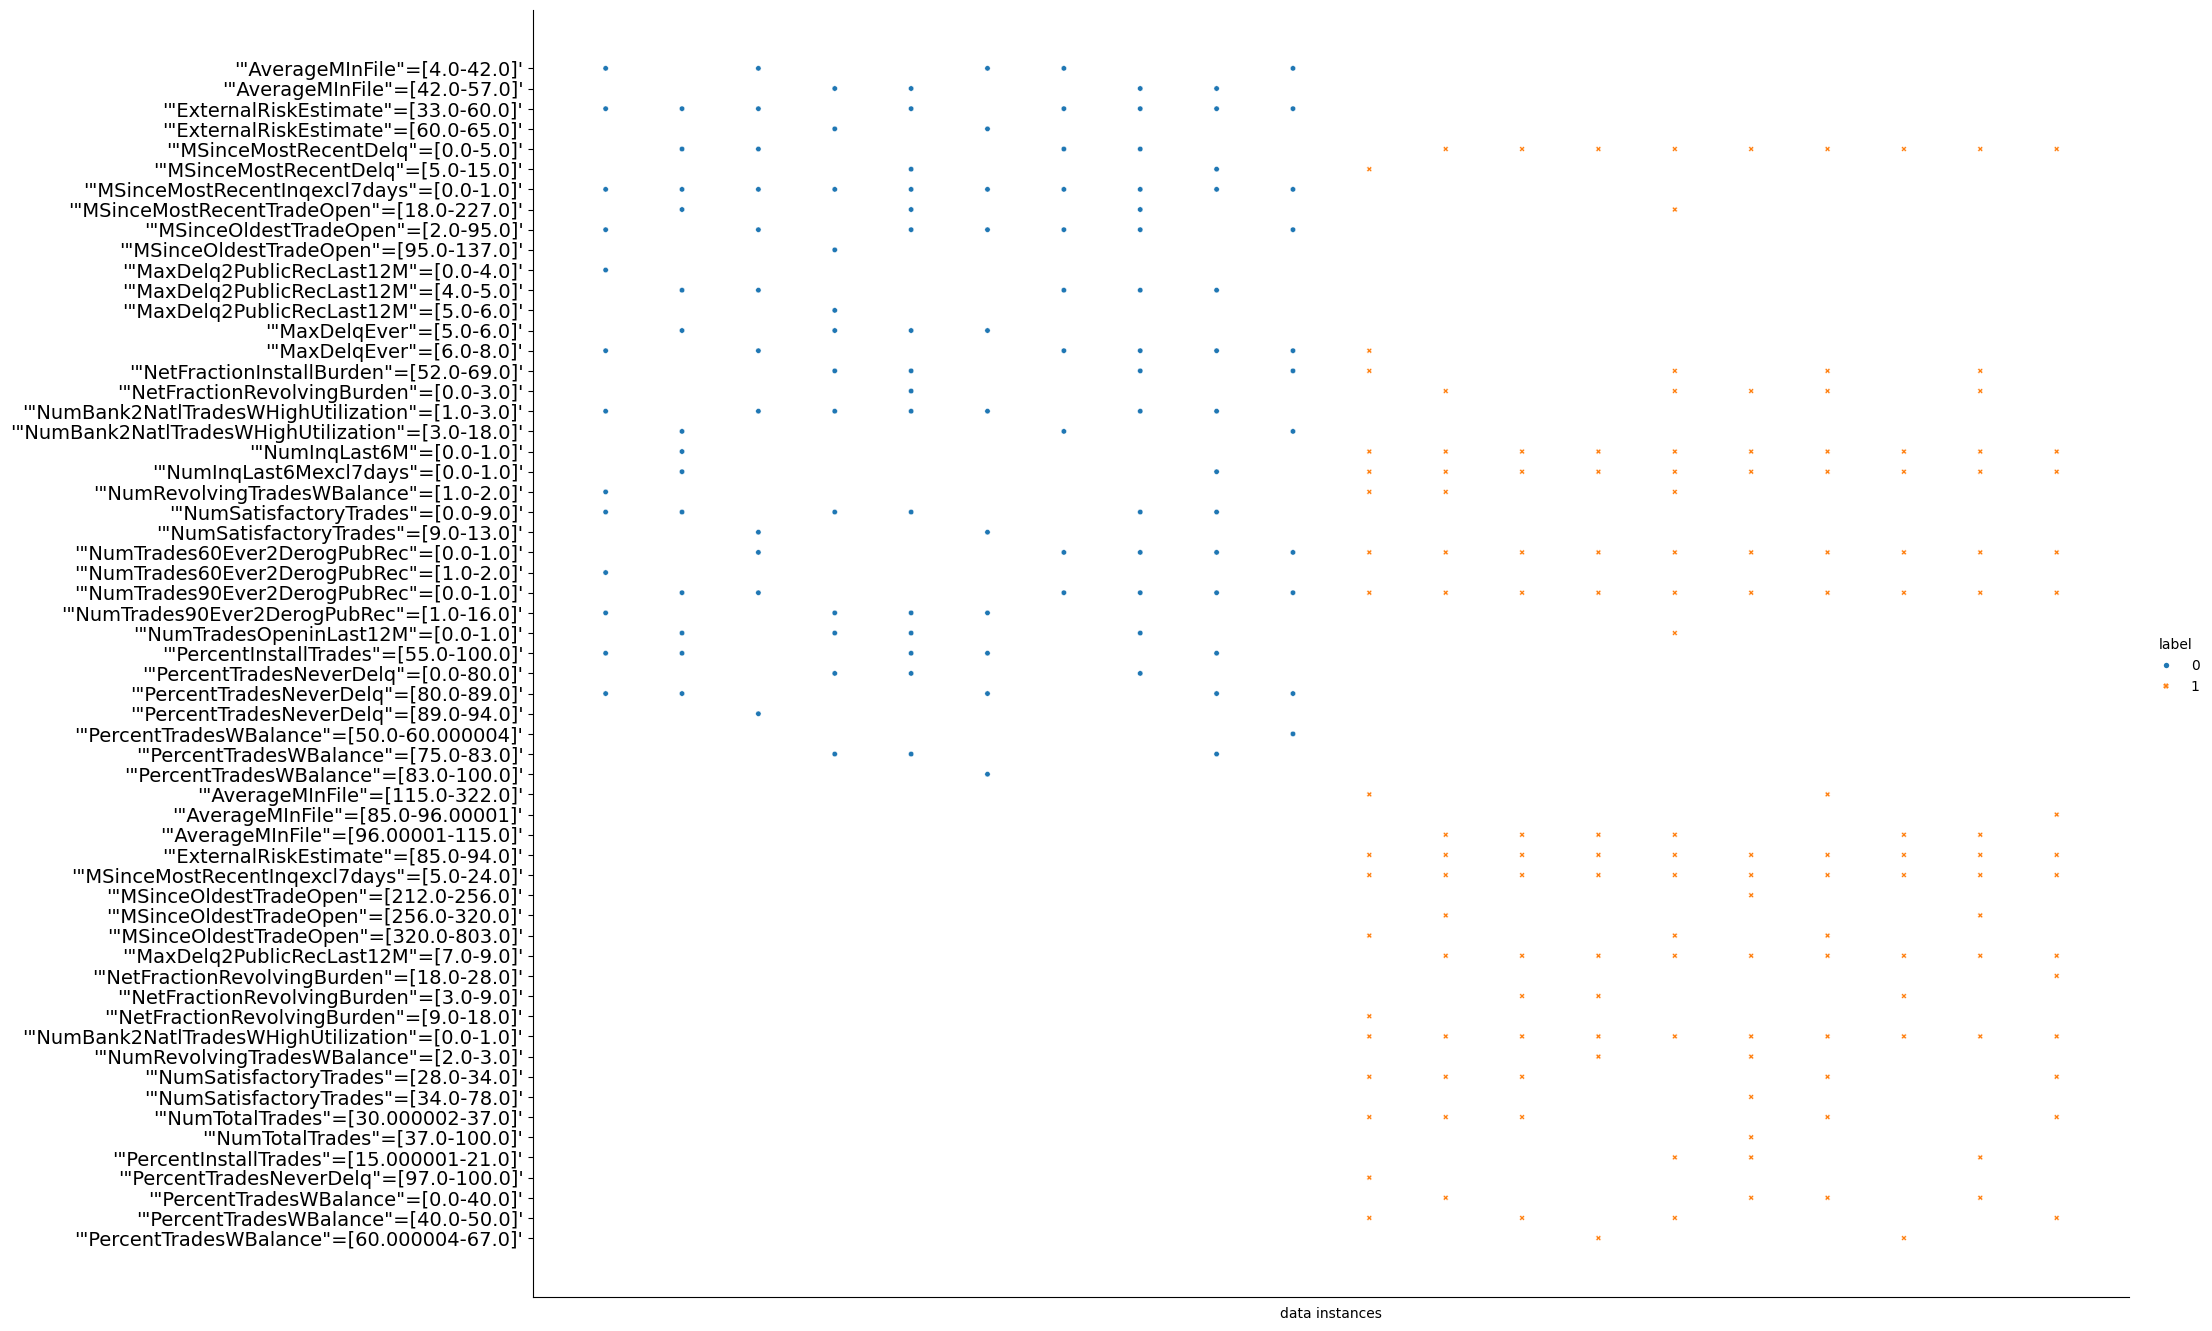

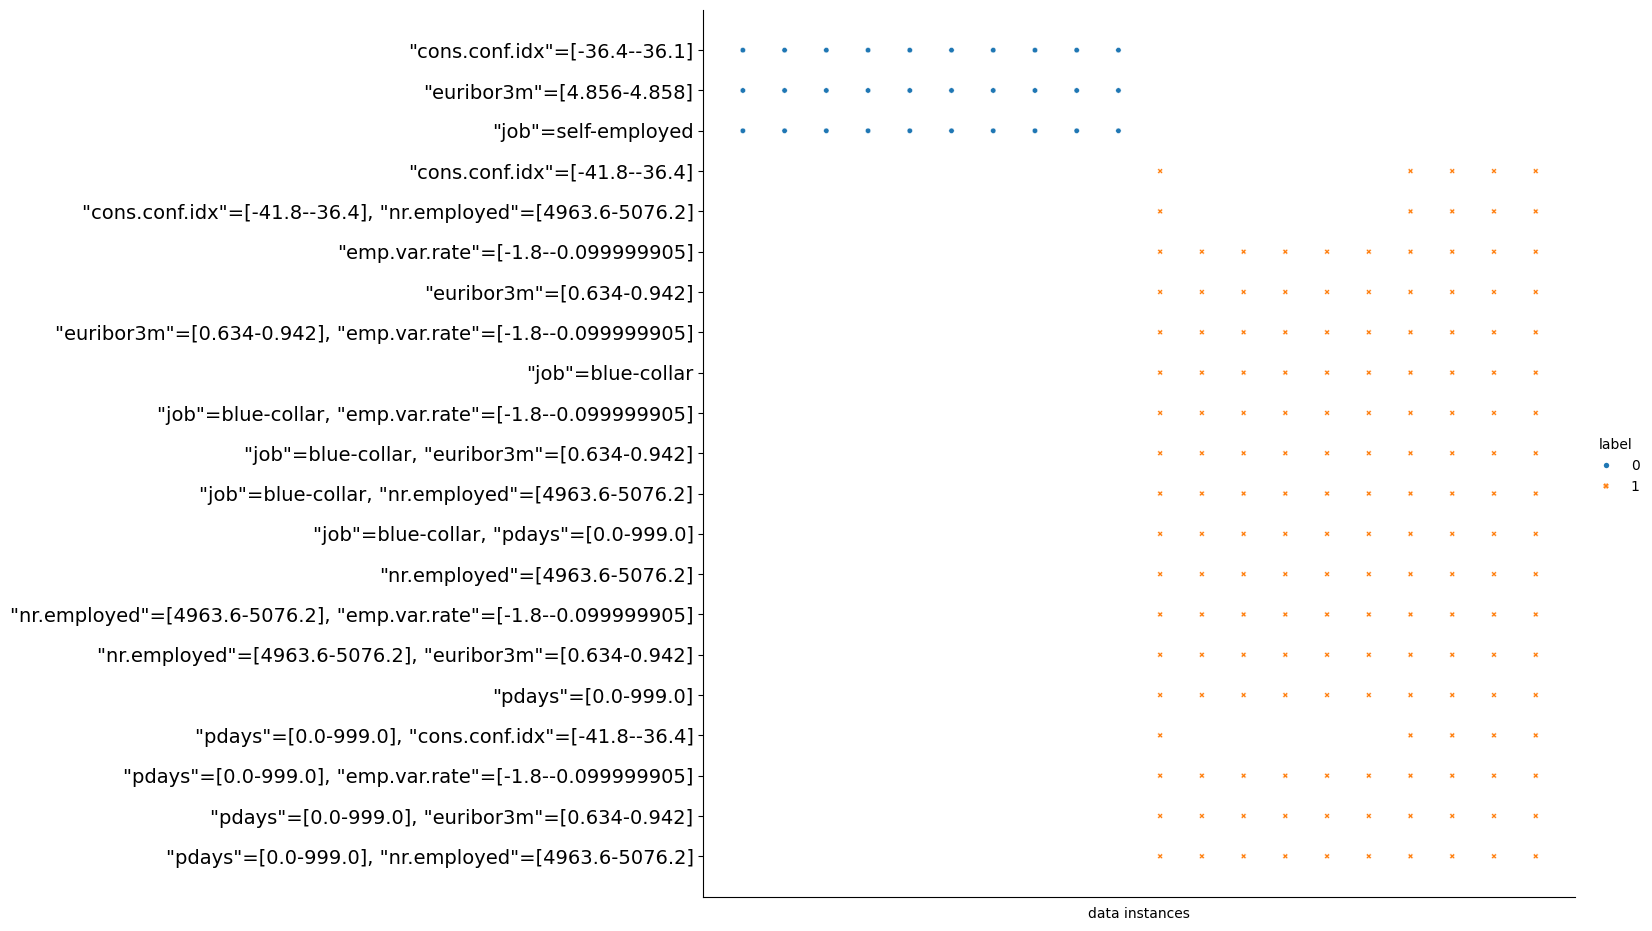

In [2]:
hugex=%timeit sum(range(1000000))
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters B, L, and G for HUI mining and data transformation
paramsByDs = {
    'pimaIndianDiabetes': {'dsName': 'pimaIndianDiabetes', 'B': 7, 'L': 1, 'G': 5e-3}, 
    'Heloc': {'dsName': 'Heloc', 'B': 8, 'L': 1, 'G': 1e-3}, 
    'BankMarketingUCI': {'dsName': 'BankMarketingUCI', 'B': 11, 'L': 2, 'G': 3e-3}
}

# Select first three datasets
selected_datasets = ['pimaIndianDiabetes', 'Heloc', 'BankMarketingUCI']

results = []

for dsName in selected_datasets:
    print(f"\n{'='*50}")
    print(f"Training and evaluating on dataset: {dsName}")
    print(f"{'='*50}")
    
    params = paramsByDs[dsName]
    
    # Load dataset
    X, y, yNewToOriginal, procdata = DataUtils().get_dataset_df(params)
    params = {**params, **procdata}
    
    # Ensure y is pandas Series
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # HUGIML classifier initialization
    clf = HUGIMLClassifier(**params)
    
    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=0, 
        stratify=y
    )
    
    # Ensure y_train and y_test remain as pandas Series
    y_train = pd.Series(y_train) if not isinstance(y_train, pd.Series) else y_train
    y_test = pd.Series(y_test) if not isinstance(y_test, pd.Series) else y_test
    
    # Prepare the data
    x_train_prepared, y_train_prepared = clf.prepareXy(x_train, y_train)
    x_test_prepared, y_test_prepared = clf.prepareXy(x_test, y_test)
    
    # Transform x by generating HUIs and fit a model
    print("\nTraining model...")
    clf.fit(x_train_prepared, y_train_prepared)
    
    # Predict probability on test instances
    print("Making predictions...")
    y_pred_proba = clf.predict_proba(x_test_prepared)
    y_pred = clf.predict(x_test_prepared)
    
    # Compute metrics
    finalRes = MetricUtils().get_metrics(y_test_prepared, y_pred, y_pred_proba)
    
    # Store results
    result = {
        'dataset': dsName,
        'accuracy': finalRes[0],
        'f1': finalRes[1],
        'auc': finalRes[2],
        'hmeasure': finalRes[3],
        'logLoss': finalRes[4],
    
    }
    results.append(result)
    
    # Display individual dataset results
    out = pd.DataFrame(finalRes).T
    out.columns = ['accuracy', 'f1', 'auc', 'hmeasure', 'logLoss', 'precision', 'recall']
    out.index = [f'performance_{dsName}']
    #display(out)
    pu = PlotUtils()
    pu.plot_relplot(clf, 20, 1)
# Combine all results into a single dataframe
final_results_LR = pd.DataFrame(results)
final_results_LR.set_index('dataset', inplace=True)
print("\nSummary of Results Across All Datasets:")
display(final_results_LR)

### HUG-BNB

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Parameters B, L, and G for HUI mining and data transformation
paramsByDs = {
    'pimaIndianDiabetes': {'dsName': 'pimaIndianDiabetes', 'B': 7, 'L': 1, 'G': 5e-3},
    'Heloc': {'dsName': 'Heloc', 'B': 5, 'L': 2, 'G': 1e-3},
    'BankMarketingUCI': {'dsName': 'BankMarketingUCI', 'B': 6, 'L': 1, 'G': 5e-4}
}

# Select first three datasets
selected_datasets = ['pimaIndianDiabetes', 'Heloc', 'BankMarketingUCI']
nfolds = 10
all_results = []

for dsName in selected_datasets:
    print(f"\n{'='*50}")
    print(f"Training and evaluating on dataset: {dsName}")
    print(f"{'='*50}")
    
    params = paramsByDs[dsName]
    
    # Load dataset
    X, y, yNewToOriginal, procdata = DataUtils().get_dataset_df(params)
    
    # Ensure y is pandas Series
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # Prepare the data using the classifier's method
    clf_prep = HUGIMLClassifierBNB()
    X_prepared, y_prepared = clf_prep.prepareXy(X, y)
    
    # Convert to numpy arrays
    Xs = X_prepared.to_numpy() if hasattr(X_prepared, 'to_numpy') else np.array(X_prepared)
    ys = y_prepared.to_numpy() if hasattr(y_prepared, 'to_numpy') else np.array(y_prepared)
    
    skf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=0)
    overallScores = [0, 0, 0, 0, 0, 0, 0]  # Acc, F1, Auc, Hmeasure, logLoss, Prec, Recall
    
    for i, (tridx, tstidx) in enumerate(skf.split(Xs, ys)):
        x_train, y_train = Xs[tridx,:], ys[tridx]
        x_test, y_test = Xs[tstidx,:], ys[tstidx]
        
        # Combine parameters
        fold_params = {
            **params,
            **procdata,
            'foldNo': i+1,
            'allCols': clf_prep.allCols,
            'origColumns': clf_prep.origColumns,
            'verbose': False
        }
        
        # Initialize classifier
        clf = HUGIMLClassifierBNB(**fold_params)
        
        # Train model
        clf.fit(x_train, y_train)
        
        # Make predictions
        y_pred_proba = clf.predict_proba(x_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Get metrics
        currScores = MetricUtils().get_metrics(y_test, y_pred, y_pred_proba)
        overallScores = [x + y for x, y in zip(overallScores, currScores)]
    
    # Calculate average across folds
    finalRes = [round(o / nfolds, 4) for o in overallScores]
    out = pd.DataFrame(finalRes).T
    out.columns = ['accuracy', 'f1', 'auc', 'hmeasure', 'logLoss', 'precision', 'recall']
    out.index = [dsName]
    
    # Store results
    all_results.append(out)
    #display(out)
    
    # Print HUI features info
    if hasattr(clf, 'procdata_'):
        print(f"\nNumber of HUI patterns generated: {len(clf.get_hug_features())}")
        print(f"Transformed feature space shape: {clf.get_transformed_shape()}")

# Combine all results
final_results_BNB = pd.concat(all_results)
final_results_BNB.drop("precision",axis=1,inplace=True)
final_results_BNB.drop("recall",axis=1,inplace=True)
print("\nSummary of Results Across All Datasets:")
display(final_results_BNB)


Training and evaluating on dataset: pimaIndianDiabetes
dataset: pimaIndianDiabetes (768, 8)  featureSize: (6, 2, 0) classSize: [(0, 500), (1, 268)]
all cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age', 'bmi', 'diabetesPedigre']
i/f cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age'] ['bmi', 'diabetesPedigreeFunction']
cat cols: []
params  : [('B', 7), ('L', 1), ('G', 0.005)]

Number of HUI patterns generated: 24
Transformed feature space shape: (692, 24)

Training and evaluating on dataset: Heloc
dataset: Heloc (9861, 23)  featureSize: (0, 23, 0) classSize: [(0, 5128), (1, 4733)]
all cols: ['NumTrades90Ever', 'NumBank2NatlTra', 'MSinceMostRecen', 'NumRevolvingTra', 'MSinceMostRecen', 'PercentTradesNe', 'MSinceOldestTra', 'NetFractionInst', 'NumInqLast6M', 'AverageMInFile']
i/f cols: [] ['NumTrades90Ever2DerogPubRec', 'NumBank2NatlTradesWHighUtilization', 'MSinceMostRecentDelq', 'NumRevolvingTradesWBalance', 'MSinceMostRecentInqexcl7d

,accuracy,f1,auc,hmeasure,logLoss
pimaIndianDiabetes,0.7578,0.6578,0.8210,0.4208,0.5395
Heloc,0.7254,0.7117,0.7803,0.2959,6.8565
BankMarketingUCI,0.8512,0.4653,0.7770,0.3295,0.6591


### HUG-LR_L1

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters B, L, and G for HUI mining and data transformation
paramsByDs = {
    'pimaIndianDiabetes': {'dsName': 'pimaIndianDiabetes', 'B': 7, 'L': 1, 'G': 5e-3}, 
    'Heloc': {'dsName': 'Heloc', 'B': 8, 'L': 1, 'G': 1e-3}, 
    'BankMarketingUCI': {'dsName': 'BankMarketingUCI', 'B': 11, 'L': 2, 'G': 3e-3}
}

# Select first three datasets
selected_datasets = ['pimaIndianDiabetes', 'Heloc', 'BankMarketingUCI']
all_results = []

for dsName in selected_datasets:
    print(f"\n{'='*50}")
    print(f"Training and evaluating on dataset: {dsName}")
    print(f"{'='*50}")
    
    params = paramsByDs[dsName]
    
    # Load dataset
    X, y, yNewToOriginal, procdata = DataUtils().get_dataset_df(params)
    params = {**params, **procdata}
    
    # Convert y to pandas Series if it isn't already
    if not isinstance(y, pd.Series):
        y = pd.Series(y, name='target')
    
    # HUGIML classifier initialization with L1 regularization
    clf = HUGIMLClassifierL1(**params)
    
    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,  # Changed to 42 for better reproducibility
        stratify=y
    )
    
    # Ensure y_train and y_test remain as pandas Series
    y_train = pd.Series(y_train, name='target') if not isinstance(y_train, pd.Series) else y_train
    y_test = pd.Series(y_test, name='target') if not isinstance(y_test, pd.Series) else y_test
    
    # Prepare the data
    print("Preparing data...")
    x_train_prepared, y_train_prepared = clf.prepareXy(x_train, y_train)
    x_test_prepared, y_test_prepared = clf.prepareXy(x_test, y_test)
    
    # Transform x by generating HUIs and fit a model
    print("Training model...")
    clf.fit(x_train_prepared, y_train_prepared)
    
    # Predict probability on test instances
    print("Making predictions...")
    y_pred_proba = clf.predict_proba(x_test_prepared)
    y_pred = clf.predict(x_test_prepared)
    
    # Compute metrics
    finalRes = MetricUtils().get_metrics(y_test_prepared, y_pred, y_pred_proba)
    
    # Store results
    result = {
        'Dataset': dsName,
        'Accuracy': finalRes[0],
        'F1 Score': finalRes[1],
        'AUC': finalRes[2],
        'H-Measure': finalRes[3],
        'Log Loss': finalRes[4],
        
    }
    all_results.append(result)
    
    # Display individual dataset results
    out = pd.DataFrame([result]).set_index('Dataset')
    #display(out)
    
    # Print HUI features info
    if hasattr(clf, 'procdata_'):
        print(f"\nNumber of HUI patterns generated: {len(clf.get_hug_features())}")
        print(f"Transformed feature space shape: {clf.get_transformed_shape()}")

# Combine all results into a single dataframe
final_results_LRL1 = pd.DataFrame(all_results).set_index('Dataset')
print("\nSummary of Results Across All Datasets:")
display(final_results_LRL1)


Training and evaluating on dataset: pimaIndianDiabetes
dataset: pimaIndianDiabetes (768, 8)  featureSize: (6, 2, 0) classSize: [(0, 500), (1, 268)]
all cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age', 'bmi', 'diabetesPedigre']
i/f cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age'] ['bmi', 'diabetesPedigreeFunction']
cat cols: []
params  : [('B', 7), ('L', 1), ('G', 0.005)]
Preparing data...
Training model...
Making predictions...

Number of HUI patterns generated: 23
Transformed feature space shape: (614, 23)

Training and evaluating on dataset: Heloc
dataset: Heloc (9861, 23)  featureSize: (0, 23, 0) classSize: [(0, 5128), (1, 4733)]
all cols: ['NumTrades90Ever', 'NumBank2NatlTra', 'MSinceMostRecen', 'NumRevolvingTra', 'MSinceMostRecen', 'PercentTradesNe', 'MSinceOldestTra', 'NetFractionInst', 'NumInqLast6M', 'AverageMInFile']
i/f cols: [] ['NumTrades90Ever2DerogPubRec', 'NumBank2NatlTradesWHighUtilization', 'MSinceMostRecentDelq'

,Accuracy,F1 Score,AUC,H-Measure,Log Loss
Dataset,,,,,
pimaIndianDiabetes,0.7338,0.5941,0.8180,0.3803,0.4942
Heloc,0.7304,0.7099,0.7991,0.3120,0.5442
BankMarketingUCI,0.8996,0.2986,0.7924,0.3541,0.2759


### LR, XGB and RF

In [16]:
baseex=%timeit sum(range(1000000))
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, 
                           log_loss, roc_auc_score)
from hmeasure import h_score

# 1. Dataset parameters
paramsByDs = {
    'pimaIndianDiabetes': {'dsName': 'pimaIndianDiabetes', 'B': 7, 'L': 1, 'G': 5e-3}, 
    'Heloc': {'dsName': 'Heloc', 'B': 8, 'L': 1, 'G': 1e-3}, 
    'BankMarketingUCI': {'dsName': 'BankMarketingUCI', 'B': 11, 'L': 2, 'G': 3e-3}
}

# 2. Define preprocessing
def preprocess_data(X, y, dsName):
    # Convert to pandas DataFrame if not already
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # Encode target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Identify categorical columns
    if dsName == 'BankMarketingUCI':
        cat_cols = ['marital', 'education', 'default', 'housing', 'loan']
        num_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                   'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    elif dsName == 'pimaIndianDiabetes':
        cat_cols = []
        num_cols = X.columns.tolist()
    elif dsName == 'Heloc':
        cat_cols = []
        num_cols = X.columns.tolist()
    
    # Ensure we only use columns that exist in the data
    cat_cols = [col for col in cat_cols if col in X.columns]
    num_cols = [col for col in num_cols if col in X.columns]
    
    return X, y_encoded, num_cols, cat_cols

# 3. Define models with preprocessing pipeline
def get_models(num_cols, cat_cols):
    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)
        ])
    
    return {
        "Logistic Regression": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42, penalty='l1', solver='liblinear'))
        ]),
        "Random Forest": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ]),
        "XGBoost": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ])
    }

# 4. Process each dataset
all_results = []

for dsName, params in paramsByDs.items():
    print(f"\n{'='*50}")
    print(f"Processing dataset: {dsName}")
    print(f"{'='*50}")
    
    # Load dataset
    X, y, yNewToOriginal, procdata = DataUtils().get_dataset_df(params)
    
    # Preprocess data
    X_processed, y_processed, num_cols, cat_cols = preprocess_data(X, y, dsName)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed
    )
    
    # Get models with proper preprocessing
    models = get_models(num_cols, cat_cols)
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)
            
            # For binary classification, use probabilities for positive class
            if y_proba.shape[1] == 2:
                y_proba = y_proba[:, 1]
            
            # Calculate metrics
            metrics = {
                'Dataset': dsName,
                'Model': model_name,
                'Accuracy': round(accuracy_score(y_test, y_pred), 4),
                'F1 Score': round(f1_score(y_test, y_pred, average='weighted'), 4),
                'Log Loss': round(log_loss(y_test, y_proba), 4),
                'AUC': round(roc_auc_score(y_test, y_proba), 4),
                'H-Measure': round(h_score(y_test, y_proba), 4)
            }
            
            all_results.append(metrics)
            
            # Print current results
            print(pd.DataFrame([metrics]).to_string(index=False))
            
        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")
            continue

# 5. Create final results dataframe
if all_results:
    results_df = pd.DataFrame(all_results)
    results_df = results_df.set_index(['Dataset', 'Model'])
    
    print("\nFINAL RESULTS ACROSS ALL DATASETS:")
    #display(results_df)
# Reorder column names to match desired output
cols = ['Accuracy', 'F1 Score', 'AUC', 'H-Measure', 'Log Loss']

# Extract data for each model using .xs (cross-section)
lr_df = results_df.xs('Logistic Regression', level='Model').loc[:, cols]
rf_df = results_df.xs('Random Forest', level='Model').loc[:, cols]
xgb_df = results_df.xs('XGBoost', level='Model').loc[:, cols]
print("Logistic Regression DF:\n")
display(lr_df)
print("Random Forest DF:\n")
display(rf_df)
print("XGBoost DF:\n")
display(xgb_df)

58.7 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Processing dataset: pimaIndianDiabetes
dataset: pimaIndianDiabetes (768, 8)  featureSize: (6, 2, 0) classSize: [(0, 500), (1, 268)]
all cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age', 'bmi', 'diabetesPedigre']
i/f cols: ['numPregnancies', 'glucose', 'bp', 'skinThickness', 'insulin', 'age'] ['bmi', 'diabetesPedigreeFunction']
cat cols: []
params  : [('B', 7), ('L', 1), ('G', 0.005)]

Training Logistic Regression...
           Dataset               Model  Accuracy  F1 Score  Log Loss    AUC  H-Measure
pimaIndianDiabetes Logistic Regression    0.7143    0.7084    0.4948 0.8224     0.3928

Training Random Forest...
           Dataset         Model  Accuracy  F1 Score  Log Loss    AUC  H-Measure
pimaIndianDiabetes Random Forest    0.7468    0.7437    0.4934 0.8153      0.365

Training XGBoost...
           Dataset   Model  Accuracy  F1 Score  Log Loss    AUC  H-Measure
pimaIndianDiabetes XGB

,Accuracy,F1 Score,AUC,H-Measure,Log Loss
Dataset,,,,,
pimaIndianDiabetes,0.7143,0.7084,0.8224,0.3928,0.4948
Heloc,0.7253,0.7249,0.7968,0.3083,0.5504
BankMarketingUCI,0.8999,0.8720,0.7775,0.3458,0.2815


Random Forest DF:



,Accuracy,F1 Score,AUC,H-Measure,Log Loss
Dataset,,,,,
pimaIndianDiabetes,0.7468,0.7437,0.8153,0.3650,0.4934
Heloc,0.7268,0.7256,0.7946,0.3058,0.5525
BankMarketingUCI,0.8886,0.8750,0.7668,0.2988,0.7003


XGBoost DF:



,Accuracy,F1 Score,AUC,H-Measure,Log Loss
Dataset,,,,,
pimaIndianDiabetes,0.7338,0.7332,0.8052,0.4019,0.7437
Heloc,0.7121,0.7117,0.7802,0.2777,0.5971
BankMarketingUCI,0.8985,0.8798,0.7960,0.3661,0.2767


### SAFE RESULTS

In [6]:
import pandas as pd

# Data
data = {
    "Accuracy": [0.692641, 0.651052, 0.887351],
    "F1 Score": [0.422764, 0.673621, 0.000000],
    "AUC": [0.784774, 0.700655, 0.700507],
    "Log Loss": [0.521972, 0.629886, 0.318771],
    "H-measure": [0.329809, 0.147809, 0.154448]
}

index = ["pimaIndianDiabetes", "Heloc", "BankMarketingUCI"]

# Create DataFrame with index
SAFE_df = pd.DataFrame(data, index=index)

# Display the DataFrame
display(SAFE_df)


,Accuracy,F1 Score,AUC,Log Loss,H-measure
pimaIndianDiabetes,0.692641,0.422764,0.784774,0.521972,0.329809
Heloc,0.651052,0.673621,0.700655,0.629886,0.147809
BankMarketingUCI,0.887351,0.000000,0.700507,0.318771,0.154448


### INAFEN RESULTS

In [7]:
import pandas as pd

# Updated evaluation metrics
data = {
    "Accuracy": [0.7532, 0.5205, 0.8880],
    "F1 Score": [0.6481, 0.0000, 0.0128],
    "AUC": [0.8442, 0.5000, 0.9649],
    "Log Loss": [0.4873, 0.6925, 0.6430],
    "H-measure": [0.4485363779765409, 0.0, 0.7899738151530966]
}

index = ["pimaIndianDiabetes", "Heloc", "BankMarketingUCI"]

# Create DataFrame
INAFEN_df = pd.DataFrame(data, index=index)

# Display the DataFrame
display(INAFEN_df)

,Accuracy,F1 Score,AUC,Log Loss,H-measure
pimaIndianDiabetes,0.7532,0.6481,0.8442,0.4873,0.448536
Heloc,0.5205,0.0000,0.5000,0.6925,0.000000
BankMarketingUCI,0.8880,0.0128,0.9649,0.6430,0.789974


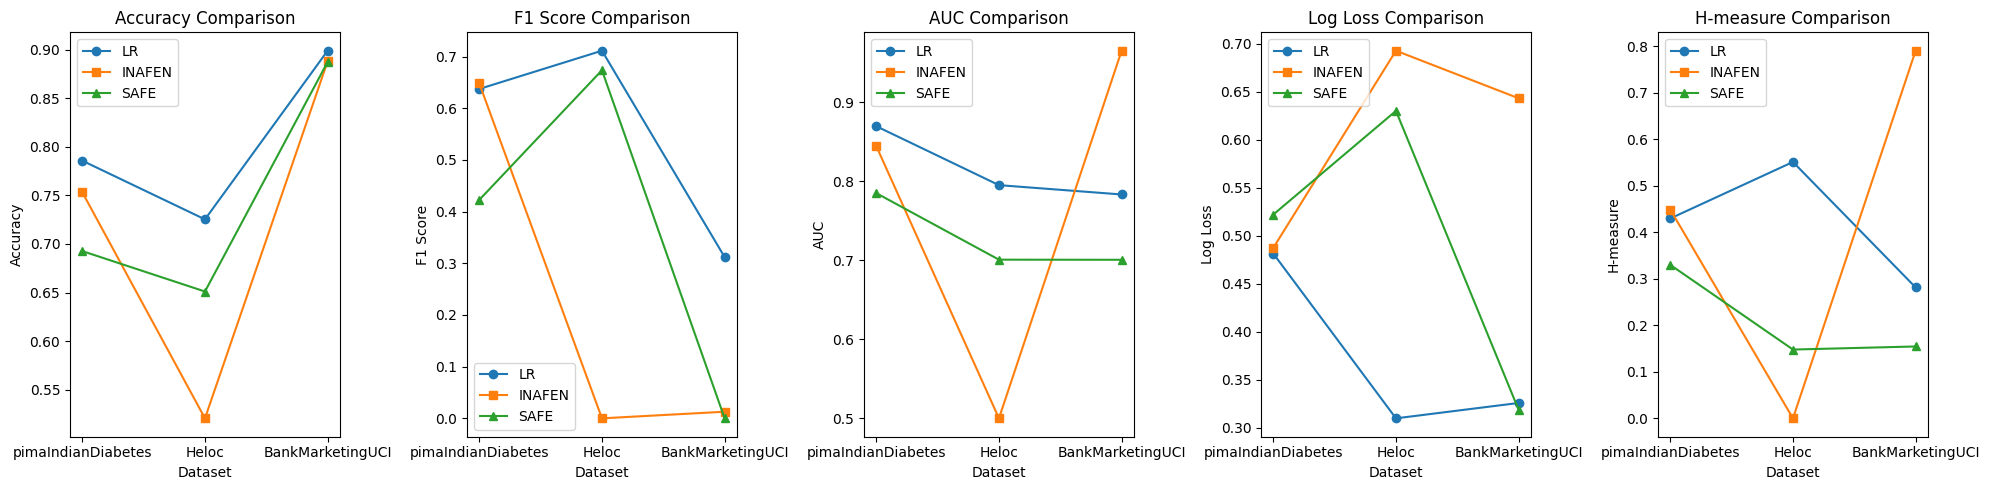

In [8]:
import matplotlib.pyplot as plt

# Define the metric names and corresponding columns
metrics = ['accuracy', 'f1', 'auc', 'hmeasure', 'logLoss']
metrics_inafen_safe = ['Accuracy', 'F1 Score', 'AUC', 'Log Loss', 'H-measure']

# Prepare the figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    # Plot for LR model
    axes[i].plot(final_results_LR.index, final_results_LR[metric], label='LR', marker='o')

    # Plot for INAFEN model
    axes[i].plot(INAFEN_df.index, INAFEN_df[metrics_inafen_safe[i]], label='INAFEN', marker='s')

    # Plot for SAFE model
    axes[i].plot(SAFE_df.index, SAFE_df[metrics_inafen_safe[i]], label='SAFE', marker='^')

    # Set labels and titles
    axes[i].set_xlabel('Dataset')
    axes[i].set_ylabel(metrics_inafen_safe[i])
    axes[i].set_title(f'{metrics_inafen_safe[i]} Comparison')
    axes[i].legend()

# Adjust layout for a neat plot
plt.tight_layout()
plt.show()


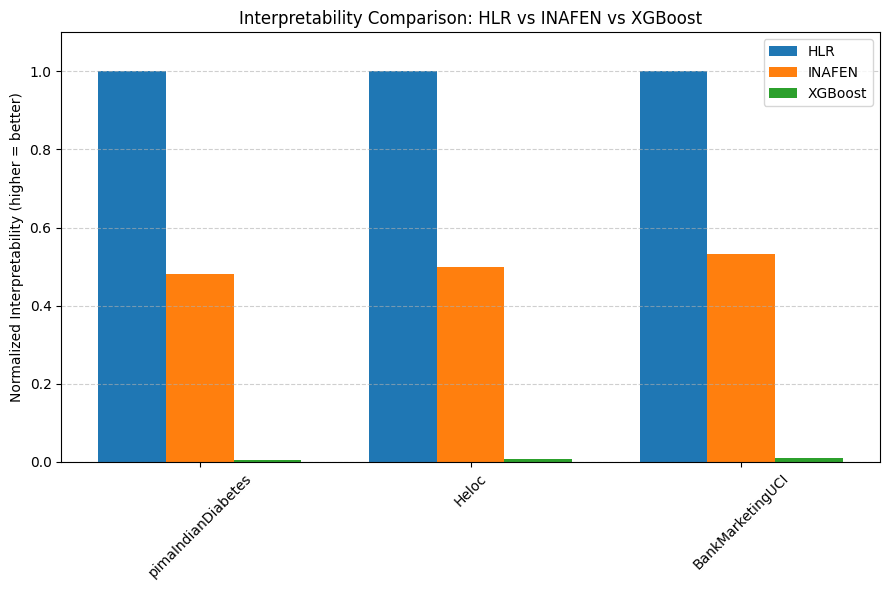

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Patch HLR parameter counts if not already saved
# Replace with actual HUG pattern counts + 1 (bias)
hlr_params_by_dataset = {
    'pimaIndianDiabetes': 25,
    'Heloc': 35,
    'BankMarketingUCI': 48
}

# Add HLR params to your results DataFrame
final_results_LR['hlr_params'] = final_results_LR.index.map(hlr_params_by_dataset)

# Step 2: Define parameter counts for INAFEN and XGB (estimate or replace as needed)
params_data = {
    'pimaIndianDiabetes': {
        'HLR': final_results_LR.loc['pimaIndianDiabetes', 'hlr_params'],
        'INAFEN': 52,
        'XGBoost': 100 * (2**4 - 1) * 3  # 100 trees, depth=3, 3 params per node
    },
    'Heloc': {
        'HLR': final_results_LR.loc['Heloc', 'hlr_params'],
        'INAFEN': 70,
        'XGBoost': 100 * (2**4 - 1) * 3
    },
    'BankMarketingUCI': {
        'HLR': final_results_LR.loc['BankMarketingUCI', 'hlr_params'],
        'INAFEN': 90,
        'XGBoost': 100 * (2**4 - 1) * 3
    }
}

# Step 3: Create DataFrame and normalize interpretability scores (higher = better)
df_chart = pd.DataFrame(params_data).T
for model in ['HLR', 'INAFEN', 'XGBoost']:
    df_chart[model + '_interpretability'] = df_chart['HLR'] / df_chart[model]
df_chart['HLR_interpretability'] = 1.0  # Normalize HLR to 1

# Step 4: Plot
plt.figure(figsize=(9, 6))
bar_width = 0.25
x = range(len(df_chart))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['HLR', 'INAFEN', 'XGBoost']

for idx, model in enumerate(labels):
    plt.bar(
        [i + bar_width * idx for i in x],
        df_chart[model + '_interpretability'],
        width=bar_width,
        label=model,
        color=colors[idx]
    )

plt.xticks([i + bar_width for i in x], df_chart.index, rotation=45)
plt.ylabel("Normalized Interpretability (higher = better)")
plt.title("Interpretability Comparison: HLR vs INAFEN vs XGBoost")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


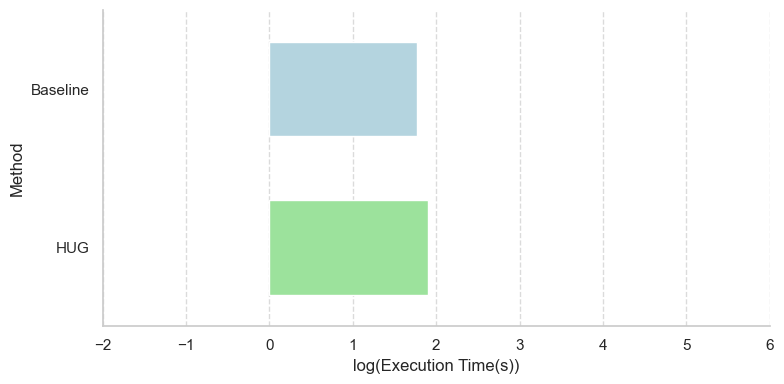

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create data
data = pd.DataFrame({
    'Method': ['Baseline', 'HUG'],
    'log_time': [np.log10(58.7), np.log10(80.1)]  # Original times converted to log scale
})

# Set style
sns.set_style("whitegrid")

# Create plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=data,
    y='Method',  # Methods on y-axis for horizontal bars
    x='log_time',  # Time on x-axis
    palette=['lightblue', 'lightgreen'],
    width=0.6
)

# Customize to match reference image
ax.set(xlabel='log(Execution Time(s))', 
       xlim=(-2, 6))  # Matches the range in your image

# Remove right and top spines
sns.despine()

# Add grid lines
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()